# Download data

In [1]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 rar amd64 2:5.5.0-1build1 [295 kB]
Fetched 295 kB in 0s (639 kB/s)
Selecting previously unselected package rar.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1build1_amd64.deb ...
Unpacking rar (2:5.5.0-1build1) ...
Setting up rar (2:5.5.0-1build1) ...
Processing triggers for man-db (2.9.1-1) ...


In [2]:
!gdown 1GrI_0YXDkg2FMvHct-k9y0geEw70wdTP

Downloading...
From: https://drive.google.com/uc?id=1GrI_0YXDkg2FMvHct-k9y0geEw70wdTP
To: /content/PH2Dataset.rar
100% 116M/116M [00:02<00:00, 40.8MB/s]


In [3]:
!unrar x -Y PH2Dataset.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from PH2Dataset.rar

Creating    PH2Dataset                                                OK
Extracting  PH2Dataset/PH2_dataset.txt                                     0%  OK 
Extracting  PH2Dataset/PH2_dataset.xlsx                                    0%  OK 
Extracting  PH2Dataset/Readme.txt                                          0%  OK 
Creating    PH2Dataset/PH2 Dataset images                             OK
Creating    PH2Dataset/PH2 Dataset images/IMD002                      OK
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image  OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp       0%  OK 
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion        OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp       0%  OK 
Creating    PH2Dataset/PH2 Dataset

# Преобразуем изображения

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

# Визуализация нескольких изображений

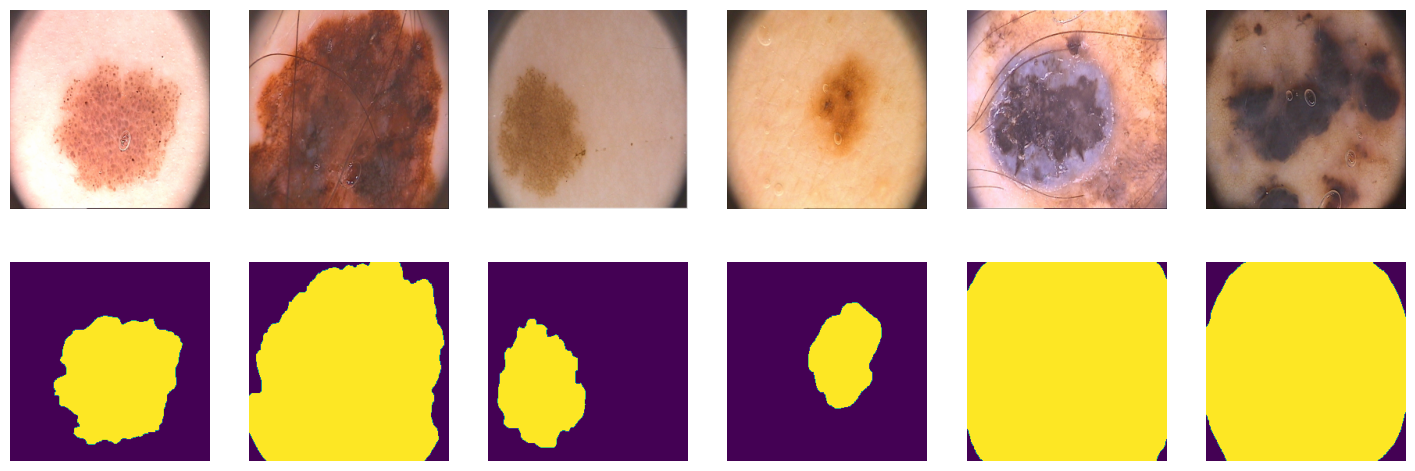

In [26]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

# Split выборок для тренировки, валидации и теста

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


# DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Первое решение архитектурой SegNet
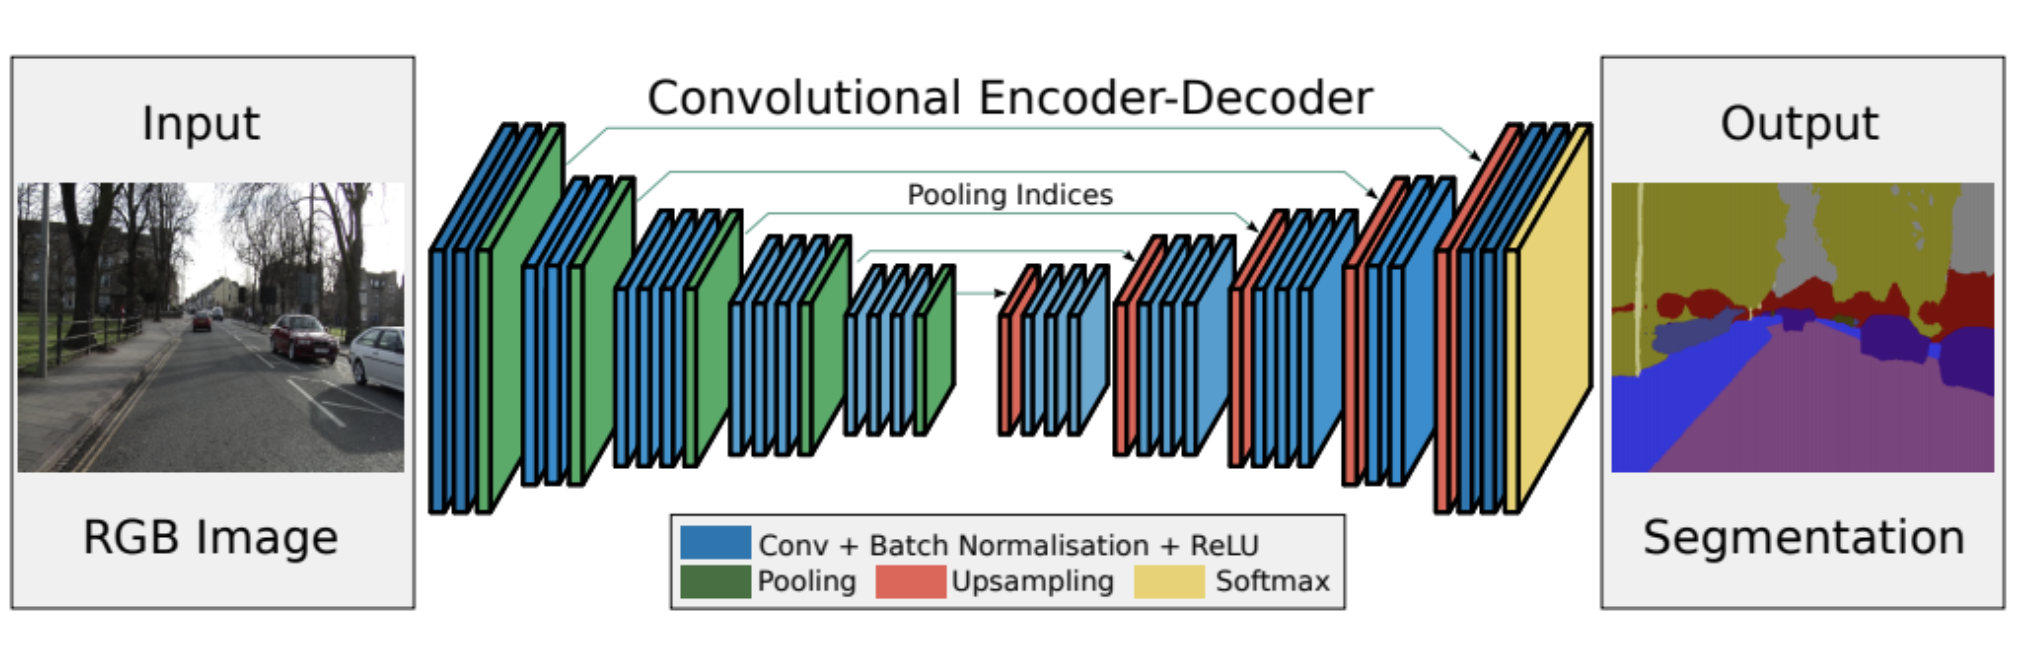

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc_conv0 = nn.Sequential(*[
        nn.Conv2d(in_channels=3,
                  out_channels=64,
                  kernel_size=3,
                  padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    ])
    self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.enc_conv1 = nn.Sequential(*[
        nn.Conv2d(in_channels=64, 
                  out_channels=128, 
                  kernel_size=3, 
                  padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    ])
    self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.enc_conv2 = nn.Sequential(*[
         nn.Conv2d(in_channels=128,
                   out_channels=256,
                   kernel_size=3,
                   padding=1),
         nn.BatchNorm2d(256),
         nn.ReLU(),
         nn.Conv2d(in_channels=256,
                   out_channels=256,
                   kernel_size=3,
                   padding=1),
         nn.BatchNorm2d(256),
         nn.ReLU(),
         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
         nn.BatchNorm2d(256),
         nn.ReLU()
    ])
    self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.enc_conv3 = nn.Sequential(*[
         nn.Conv2d(in_channels=256,
                   out_channels=512,
                   kernel_size=3,
                   padding=1),
         nn.BatchNorm2d(512),
         nn.ReLU(),
         nn.Conv2d(in_channels=512,
                   out_channels=512, 
                   kernel_size=3, 
                   padding=1),
         nn.BatchNorm2d(512),
         nn.ReLU(),
         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
         nn.BatchNorm2d(512),
         nn.ReLU()
    ])
    self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
    self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv0 = nn.Sequential(*[
        nn.Conv2d(in_channels=512,
                   out_channels=512,
                   kernel_size=3,
                   padding=1),
         nn.BatchNorm2d(512),
         nn.ReLU(),
         nn.Conv2d(in_channels=512,
                   out_channels=512, 
                   kernel_size=3, 
                   padding=1),
         nn.BatchNorm2d(512),
         nn.ReLU(),
         nn.Conv2d(in_channels=512, 
                   out_channels=256,
                   kernel_size=3, 
                   padding=1),
         nn.BatchNorm2d(256),
         nn.ReLU()
    ])
    self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv1 = nn.Sequential(*[
         nn.Conv2d(in_channels=256, 
                   out_channels=256,
                   kernel_size=3, 
                   padding=1),
         nn.BatchNorm2d(256),
         nn.ReLU(),
         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
         nn.BatchNorm2d(256),
         nn.ReLU(),
         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
         nn.BatchNorm2d(128),
         nn.ReLU()
    ]) 
    self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.dec_conv2 = nn.Sequential(*[
         nn.Conv2d(in_channels=128,
                   out_channels=128,
                   kernel_size=3,
                   padding=1),
         nn.BatchNorm2d(128),
         nn.ReLU(),
         nn.Conv2d(in_channels=128, 
                   out_channels=64, 
                   kernel_size=3,
                   padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    ]) 
    self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
    self.dec_conv3 = nn.Sequential(*[
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, 
                  out_channels=1, 
                  kernel_size=3,
                  padding=1),
                            
    ]) 
  def forward(self, x):
    size_0 = x.size()
    e0, id0 = self.pool0(self.enc_conv0(x))

    size_1 = e0.size()
    e1, id1 = self.pool1(self.enc_conv1(e0))

    size_2 = e1.size()
    e2, id2 = self.pool2(self.enc_conv2(e1))

    size_3 = e2.size()
    e3, id3 = self.pool3(self.enc_conv3(e2))

    d0 = self.dec_conv0(self.upsample0(e3, id3, output_size=size_3))
    d1 = self.dec_conv1(self.upsample1(e2, id2, output_size=size_2))
    d2 = self.dec_conv2(self.upsample2(e1, id1, output_size=size_1))
    d3 = self.dec_conv3(self.upsample3(e0, id0, output_size=size_0))

    return d3


# Метрика качества IoU (Intersection over Union), использующее отношение площадей ограничивающих рамок

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  

# За функцию потерь позьмем [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

In [14]:
def bce_loss(y_real, y_pred):
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1)
    
    epsilon = 10 ** -44
    result = - torch.mean(
        y_real * torch.log(torch.sigmoid(y_pred) + epsilon) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + epsilon)
    )

    return result

# Train

In [15]:
import time
import copy
import seaborn as sns
import gc

In [16]:
def train(model, optimizer, loss_fn, epochs, data):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_iou = 0.0
    
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_iou = []
    epoch_val_iou = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_iou = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    Y_pred = model(inputs)
                    loss = loss_fn(labels, Y_pred)
                    
                    # forward-pass
                    if phase == 'train':
                        loss.backward()  # backward-pass
                        optimizer.step()

                running_loss += loss.detach().item() * inputs.size(0)
                Y_pred = torch.sigmoid(Y_pred)
                Y_pred = torch.where(Y_pred > 0.5, 1, 0)
                running_iou += iou_pytorch(Y_pred, labels).mean().item()
                
            
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])
            
            if phase == 'train':
                epoch_train_loss.append(epoch_loss)
                epoch_train_iou.append(epoch_iou)
            else:
                epoch_val_loss.append(epoch_loss)
                epoch_val_iou.append(epoch_iou)
                

#             print('{} Loss: {:.4f} IOU: {:.4f}'.format(
#                     phase, epoch_loss, epoch_iou))
            
            if phase == 'val':
                Y_pred = Y_pred.detach().cpu()
                clear_output(wait=True)
                for k in range(5):
                    plt.subplot(2, 5, k+1)
                    plt.imshow(np.rollaxis(inputs[k].cpu().numpy(), 0, 3), cmap='gray')
                    plt.title('Real', fontsize=12)
                    
                    plt.axis('off')

                    plt.subplot(2, 5, k+6)
                    plt.imshow(Y_pred[k, 0], cmap='gray')
                    plt.title('Output', fontsize=12)
                    plt.axis('off')
                plt.suptitle('val Loss: {:.4f} val IOU: {:.4f}'.format(epoch_loss, epoch_iou), fontsize=15)
                plt.show()
                
            inputs, labels = inputs.cpu(), labels.cpu()
            Y_pred, loss = Y_pred.cpu(), loss.cpu()
            #running_loss, running_iou = running_loss.cpu(), running_iou.cpu()
            #epoch_loss, epoch_iou = epoch_loss.cpu(), epoch_iou.cpu()
            del inputs, labels, Y_pred, loss, #running_loss, running_iou, epoch_loss, epoch_iou
            torch.cuda.empty_cache()
            gc.collect()
            
            
            if phase == 'val' and epoch_iou > best_iou:
                best_iou = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val IOU: {:4f}'.format(best_iou))
    
    
    model.load_state_dict(best_model_wts)
    statistics = epoch_train_loss, epoch_train_iou, epoch_val_loss, epoch_val_iou
    #torch.save(model.state_dict(), '/')
    return model, statistics

In [17]:
dataloaders = {}
dataloaders['train'], dataloaders['val'], dataloaders['test'] = data_tr, data_val, data_ts

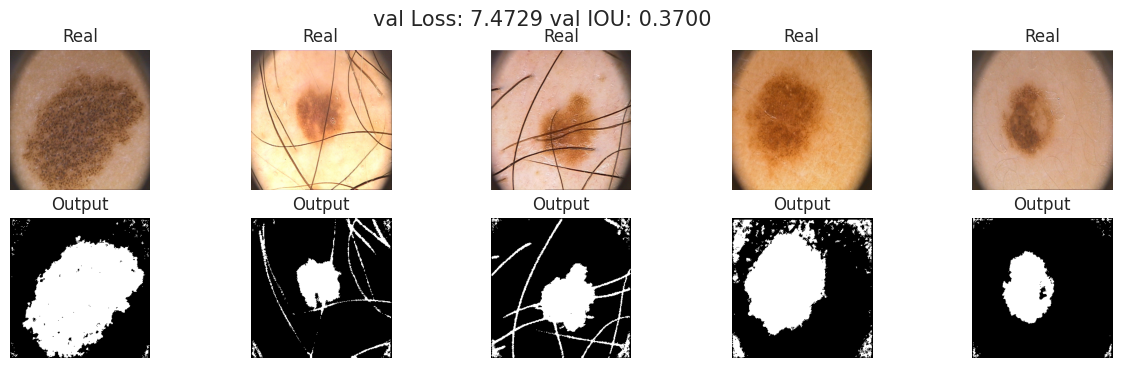


Training complete in 1m 32s
Best val IOU: 0.372000


In [ ]:
model_bce = SegNet().to(device)
max_epochs = 20
optim = torch.optim.Adam(model_bce.parameters(), lr=1e-4) 
segnet_best_model_bce, segnet_statistics_with_bce_loss = train(model_bce, optim, bce_loss, max_epochs, dataloaders)

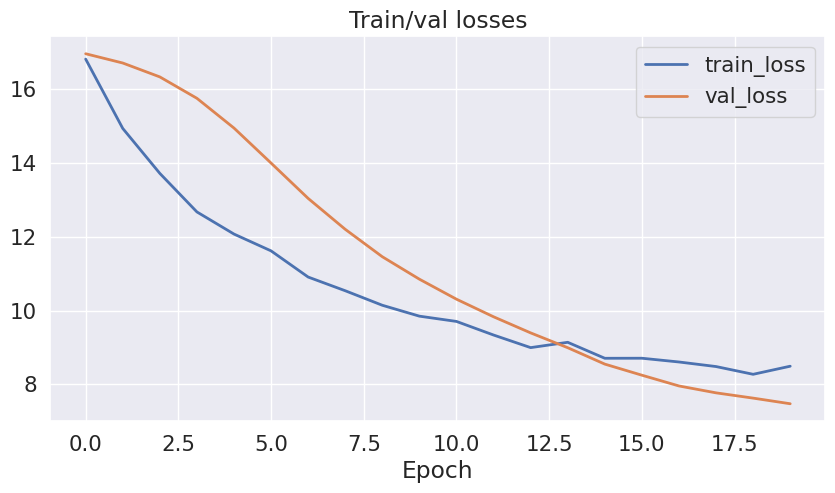

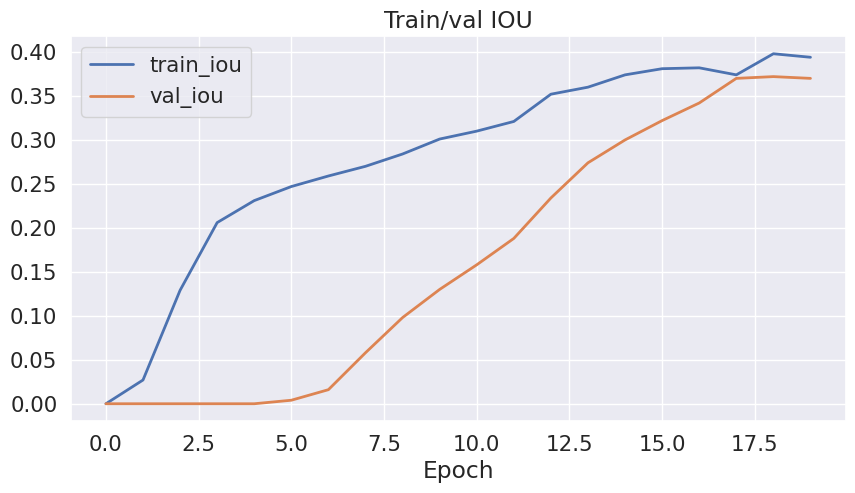

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)


plt.figure(figsize=(10, 5))
plt.title("Train/val losses")
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[0], label="train_loss", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[2], label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Train/val IOU")
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[1], label="train_iou", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[3], label="val_iou", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

# Inference

In [59]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [60]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = torch.where(Y_pred > 0.5, 1, 0)

            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/ len(data)

In [ ]:
score_model(model_bce, iou_pytorch, data_ts)

0.4099999964237213

# Попробуем с другой функцией потерь

In [ ]:
def dice_loss(targets, inputs):
    
    smooth=1e-6
    inputs = torch.flatten(torch.sigmoid(inputs))
    targets = torch.flatten(targets)
    
    intersection = torch.sum(inputs * targets)
    cardinality = torch.sum(inputs + targets)
    
    dice_score = 2. * intersection / (cardinality + smooth)
    return torch.mean(1. - dice_score)

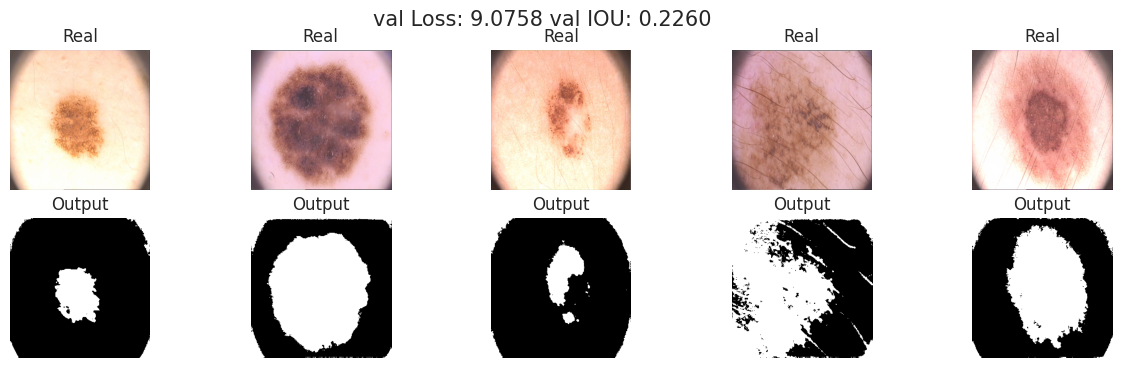


Training complete in 1m 34s
Best val IOU: 0.226000


In [ ]:
model_dice = SegNet().to(device)
max_epochs = 20
optim = torch.optim.Adam(model_dice.parameters(), lr=1e-4) 
segnet_best_model_dice, segnet_statistics_with_dice_loss = train(model_dice, optim, dice_loss, max_epochs, dataloaders)

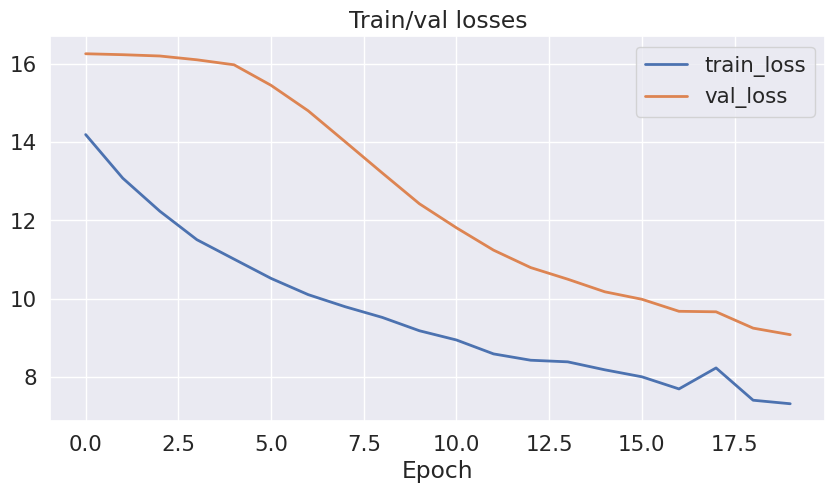

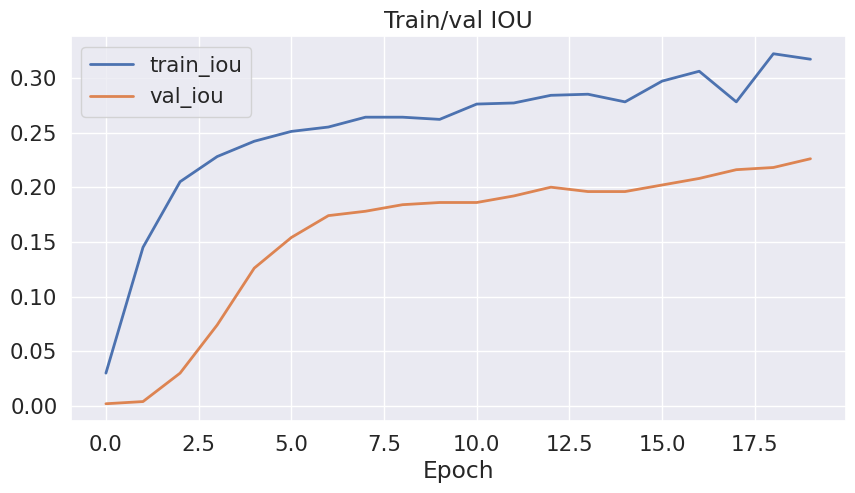

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)


plt.figure(figsize=(10, 5))
plt.title("Train/val losses")
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[0], label="train_loss", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[2], label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Train/val IOU")
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[1], label="train_iou", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[3], label="val_iou", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

0.2879999876022339

# И еще одну, которая является вариацией BCE, но взвешивает пиксель по степени уверенности, для дкомпинсации несбалансированности классов

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1) 
    
    result = -torch.mean(
        ((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(
        1 - torch.sigmoid(y_pred) + eps))
    return result

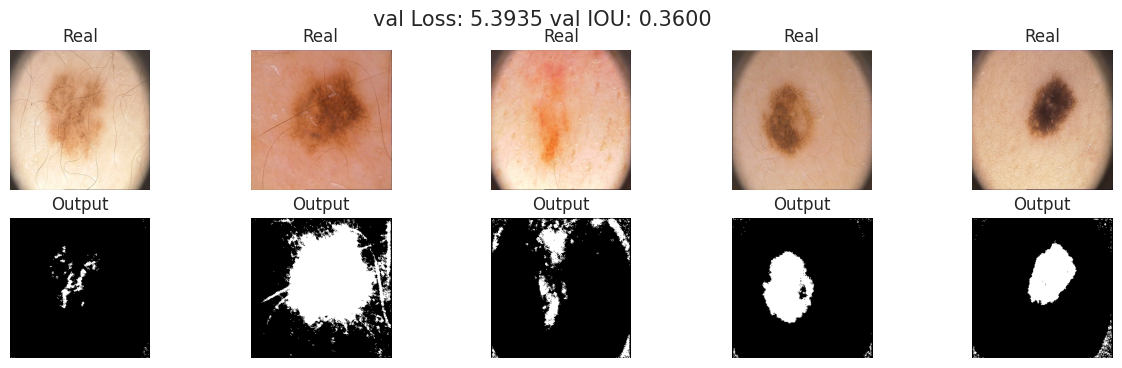


Training complete in 1m 37s
Best val IOU: 0.364000


In [ ]:
model_focal = SegNet().to(device)
max_epochs = 20
optim = torch.optim.Adam(model_focal.parameters(), lr=1e-4) 
segnet_best_model_focal, segnet_statistics_with_focal_loss = train(model_focal, optim, focal_loss, max_epochs, dataloaders)

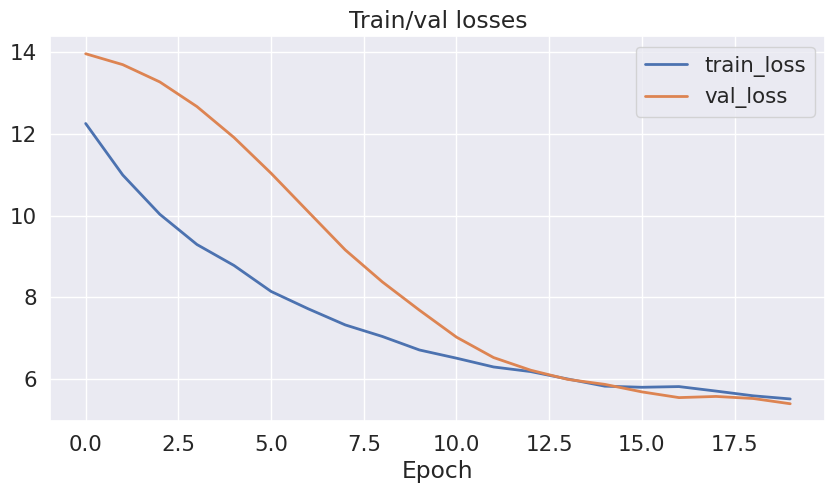

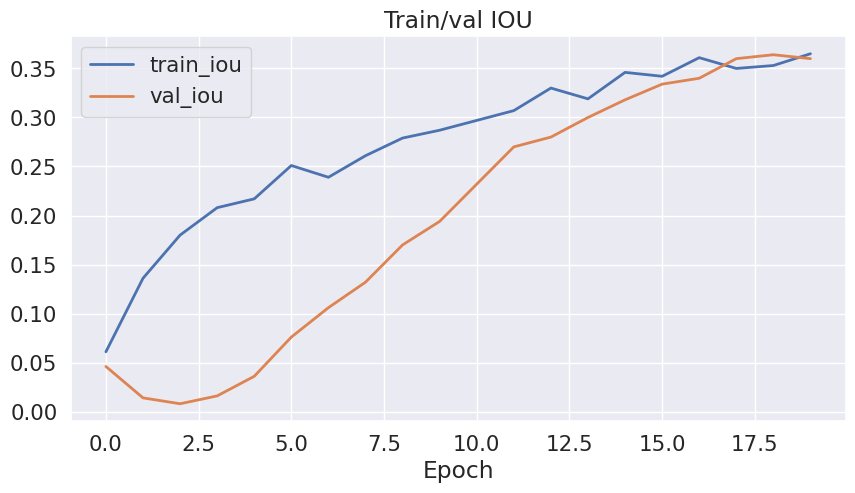

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)


plt.figure(figsize=(10, 5))
plt.title("Train/val losses")
plt.plot(range(max_epochs), segnet_statistics_with_focal_loss[0], label="train_loss", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_focal_loss[2], label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Train/val IOU")
plt.plot(range(max_epochs), segnet_statistics_with_focal_loss[1], label="train_iou", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_focal_loss[3], label="val_iou", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
score_model(model_focal, iou_pytorch, data_ts)

0.40199998021125793

# UNet

In [33]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc_conv0 = nn.Sequential(*[
        nn.Conv2d(in_channels=3, 
                  out_channels=64,
                  kernel_size=3,
                  padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    ])
    self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.enc_conv1 = nn.Sequential(*[
      nn.Conv2d(in_channels=64, 
                out_channels=128,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(in_channels=128,
                out_channels=128,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU()
    ])
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.enc_conv2 = nn.Sequential(*[
      nn.Conv2d(in_channels=128, 
                out_channels=256,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(in_channels=256,
                out_channels=256,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU()
    ])
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.enc_conv3 = nn.Sequential(*[
      nn.Conv2d(in_channels=256, 
                out_channels=512,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(in_channels=512,
                out_channels=512,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU()
    ])
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bottleneck_conv = nn.Sequential(*[
      nn.Conv2d(in_channels=512, 
                out_channels=1024,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(1024),
      nn.ReLU(),
      nn.Conv2d(in_channels=1024,
                out_channels=1024,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(1024),
      nn.ReLU()
    ])

    self.upsample0 = nn.Upsample(32)
    self.dec_conv0 = nn.Sequential(*[
      nn.Conv2d(in_channels=1024 + 512, 
                out_channels=512,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.Conv2d(in_channels=512,
                out_channels=512,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU()
    ])
    self.upsample1 = nn.Upsample(64)
    self.dec_conv1 = nn.Sequential(*[
      nn.Conv2d(in_channels=512 + 256, 
                out_channels=256,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.Conv2d(in_channels=256,
                out_channels=256,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU()
    ])
    self.upsample2 = nn.Upsample(128)
    self.dec_conv2 = nn.Sequential(*[
      nn.Conv2d(in_channels=256 + 128, 
                out_channels=128,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(in_channels=128,
                out_channels=128,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU()
    ])
    self.upsample3 = nn.Upsample(256)
    self.dec_conv3 = nn.Sequential(*[
      nn.Conv2d(in_channels=128 + 64, 
                out_channels=64,
                kernel_size=3,
                padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(in_channels=64,
                out_channels=1,
                kernel_size=3,
                padding=1)
    ])
  def forward(self, x):
    e0 = self.enc_conv0(x)
    e1 = self.enc_conv1(self.pool0(e0))
    e2 = self.enc_conv2(self.pool1(e1))
    e3 = self.enc_conv3(self.pool2(e2))

    b = self.bottleneck_conv(self.pool3(e3))

    d0 = self.upsample0(b)
    d0 = torch.cat([d0, e3], dim=1)
    d0 = self.dec_conv0(d0)

    d1 = self.upsample1(d0)
    d1 = torch.cat([d1, e2], dim=1)
    d1 = self.dec_conv1(d1)

    d2 = self.upsample2(d1)
    d2 = torch.cat([d2, e1], dim=1)
    d2 = self.dec_conv2(d2)

    d3 = self.upsample3(d2)
    d3 = torch.cat([d3, e0], dim=1)
    d3 = self.dec_conv3(d3)# no activation
        
    return d3

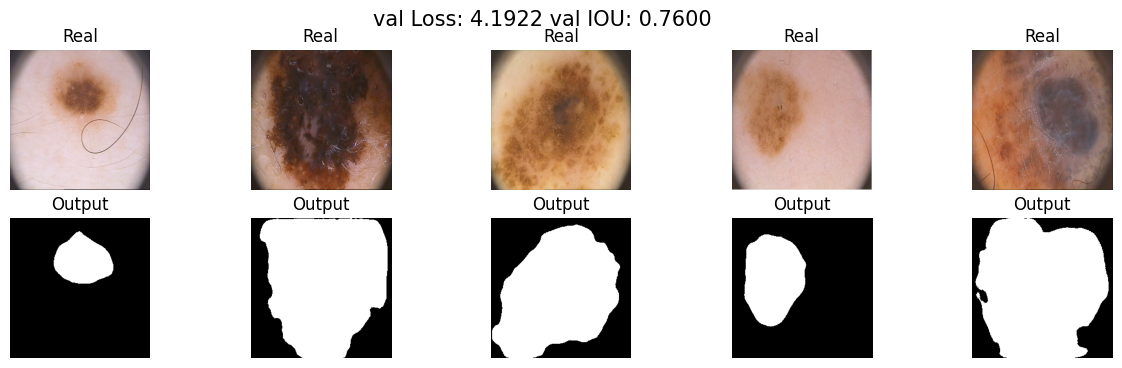


Training complete in 2m 44s
Best val IOU: 0.760000


In [56]:
model_bce_unet = UNet().to(device)
max_epochs = 20
optim = torch.optim.Adam(model_bce_unet.parameters(), lr=1e-4) 
unet_best_model_bce, unet_statistics_with_bce_loss = train(model_bce_unet, optim, bce_loss, max_epochs, dataloaders)

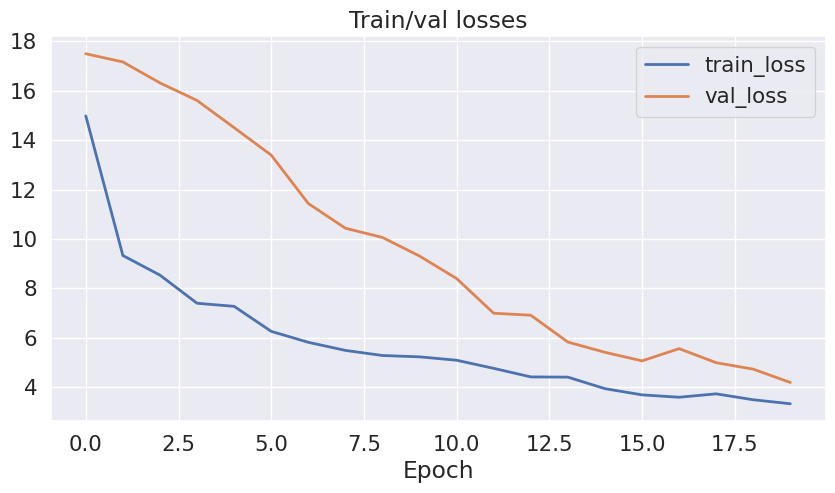

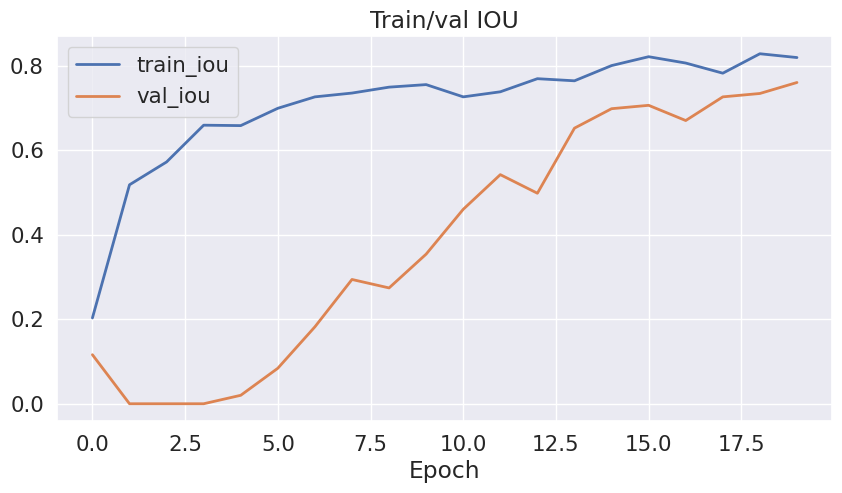

In [57]:
sns.set(style="darkgrid", font_scale=1.4)


plt.figure(figsize=(10, 5))
plt.title("Train/val losses")
plt.plot(range(max_epochs), unet_statistics_with_bce_loss[0], label="train_loss", linewidth=2)
plt.plot(range(max_epochs), unet_statistics_with_bce_loss[2], label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Train/val IOU")
plt.plot(range(max_epochs), unet_statistics_with_bce_loss[1], label="train_iou", linewidth=2)
plt.plot(range(max_epochs), unet_statistics_with_bce_loss[3], label="val_iou", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [61]:
score_model(model_bce_unet, iou_pytorch, data_ts)

0.7380000054836273

In [55]:
torch.cuda.empty_cache()

In [53]:
del optim

In [54]:
import gc
gc.collect()

2813